### | Turbine Status Detector |

In [101]:
#importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm import tqdm
import random
from PIL import Image
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
warnings.filterwarnings('ignore')


In [102]:
#Load the dataset
BASE_DIR = "E:/College Lab Work/MINOR PROJECT/Performance Prediction of Turbine Blades/Image Data/Turbine Pics - Copy/"


In [103]:
image_paths = []
status_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    status = str(temp[0])
    image_paths.append(image_path)

    if status=='Damaged':
        status_labels.append(1)
    else:
        status_labels.append(0)

100%|██████████| 14/14 [00:00<?, ?it/s]


In [104]:
#convert to DataFrame
df = pd.DataFrame()
df['Image'], df['Status'] = image_paths, status_labels
df

,Image,Status
0,E:/College Lab Work/MINOR PROJECT/Performance ...,1
1,E:/College Lab Work/MINOR PROJECT/Performance ...,1
2,E:/College Lab Work/MINOR PROJECT/Performance ...,1
3,E:/College Lab Work/MINOR PROJECT/Performance ...,1
4,E:/College Lab Work/MINOR PROJECT/Performance ...,1
5,E:/College Lab Work/MINOR PROJECT/Performance ...,1
6,E:/College Lab Work/MINOR PROJECT/Performance ...,1
7,E:/College Lab Work/MINOR PROJECT/Performance ...,0
8,E:/College Lab Work/MINOR PROJECT/Performance ...,0
9,E:/College Lab Work/MINOR PROJECT/Performance ...,0


## Feature Extraction


In [105]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [106]:
X = extract_features(df['Image'])

100%|██████████| 14/14 [00:00<00:00, 78.45it/s]


In [107]:
X.shape

(14, 128, 128, 1)

In [108]:
# normalize the images
X = X/255.0

In [109]:
Y_status = df['Status']

In [110]:
input_shape = (128, 128, 1)

## | Model Creation |

In [111]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [112]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Training

In [113]:
# train model
history = model.fit(x=X, y=Y_status, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 1.3286 - gender_out_loss: 0.6923 - age_out_loss: 0.6362 - gender_out_accuracy: 0.5455 - age_out_accuracy: 0.3636 - val_loss: 1.5577 - val_gender_out_loss: 0.9643 - val_age_out_loss: 0.5933 - val_gender_out_accuracy: 0.0000e+00 - val_age_out_accuracy: 0.3333
Epoch 2/30
1/1 [==============================] - 0s 163ms/step - loss: 1.0355 - gender_out_loss: 0.6285 - age_out_loss: 0.4070 - gender_out_accuracy: 0.6364 - age_out_accuracy: 0.7273 - val_loss: 4.5163 - val_gender_out_loss: 1.8922 - val_age_out_loss: 2.6241 - val_gender_out_accuracy: 0.0000e+00 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 0s 172ms/step - loss: 2.9886 - gender_out_loss: 0.7458 - age_out_loss: 2.2428 - gender_out_accuracy: 0.6364 - age_out_accuracy: 0.6364 - val_loss: 1.8683 - val_gender_out_loss: 0.9894 - val_age_out_loss: 0.8789 - val_gender_out_accuracy: 0.0000e+00 - val_age_out_accuracy: 0.0000e+00
Epoch

## Predict with Training Data

Original Status :  Undamaged
1/1 [==============================] - 0s 21ms/step
Predicted Status :  Undamaged


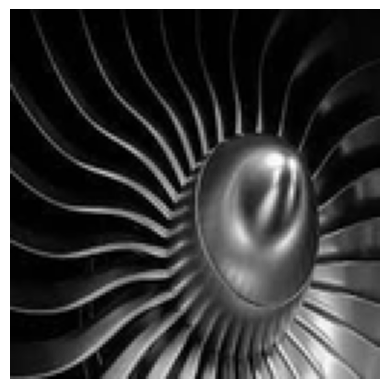

In [132]:
import math
image_index = 8

if Y_status[image_index] == 1:
    print('Original Status : ', 'Damaged')
else:
    print('Original Status : ', 'Undamaged')
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_status = np.round(pred[0][0], 1)

threshold = 0.5
predicted_class = 1 if pred[0][0] >= threshold else 0

if predicted_class == 1:
    print("Predicted Status : ", 'Damaged')
else:
    print("Predicted Status : ", 'Undamaged')
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')

Original Status :  Damaged
1/1 [==============================] - 0s 38ms/step
Predicted Status :  Damaged


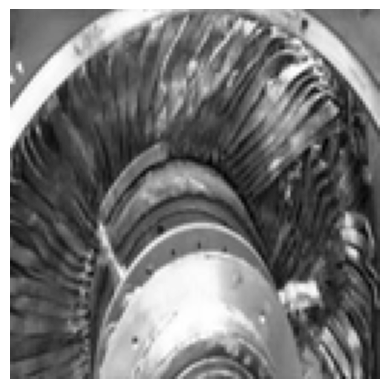

In [131]:
import math
image_index = 1

if Y_status[image_index] == 1:
    print('Original Status : ', 'Damaged')
else:
    print('Original Status : ', 'Undamaged')
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_status = np.round(pred[0][0], 1)

threshold = 0.5
predicted_class = 1 if pred[0][0] >= threshold else 0

if predicted_class == 1:
    print("Predicted Status : ", 'Damaged')
else:
    print("Predicted Status : ", 'Undamaged')
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')


## Prediction with Test Data

In [133]:
image_path = "E:\College Lab Work\MINOR PROJECT\Performance Prediction of Turbine Blades\Image Data\Testing Data\Damaged_Turbine_Blade.jfif" # path of the image
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)

pred_status = np.round(pred[0][0], 1)

threshold = 0.5
predicted_class = 1 if pred[0][0] >= threshold else 0

if predicted_class == 1:
    print("Predicted Status : ", 'Damaged')
else:
    print("Predicted Status : ", 'Undamaged')
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')



UnimplementedError: Graph execution error:

Detected at node 'model_3/conv2d_12/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\HP\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "c:\Users\HP\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "c:\Users\HP\anaconda3\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HP\AppData\Local\Temp\ipykernel_15864\2048158796.py", line 6, in <module>
      pred = model.predict(img)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 321, in call
      return self.activation(outputs)
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\activations.py", line 321, in relu
      return backend.relu(
    File "c:\Users\HP\anaconda3\Lib\site-packages\keras\src\backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'model_3/conv2d_12/Relu'
Fused conv implementation does not support grouped convolutions for now.
	 [[{{node model_3/conv2d_12/Relu}}]] [Op:__inference_predict_function_24757]